### This exercise is designed to pair with [this tutorial](https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial). If you haven't taken a look at it yet, head over and check it out first. (Otherwise these exercises will be pretty confusing!) -- Rachael 

# Stocking rental bikes

![bike rentals](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Bay_Area_Bike_Share_launch_in_San_Jose_CA.jpg/640px-Bay_Area_Bike_Share_launch_in_San_Jose_CA.jpg)

You stock bikes for a bike rental company in Austin, ensuring stations have enough bikes for all their riders. You decide to build a model to predict how many riders will start from each station during each hour, capturing patterns in seasonality, time of day, day of the week, etc.

To get started, create a project in GCP and connect to it by running the code cell below. Make sure you have connected the kernel to your GCP account in Settings.

In [174]:
# Set your own project id here
PROJECT_ID = 'decoded-pilot-579' # a string, like 'kaggle-bigquery-240818'
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('model_dataset', exists_ok=True)


#from google.cloud.bigquery import magics
#from kaggle_gcp import KaggleKernelCredentials
#magics.context.credentials = KaggleKernelCredentials()
#magics.context.project = PROJECT_ID

In [175]:
#import os
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/root/.kaggle/gcplogin.json'

In [176]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## Linear Regression

Your dataset is quite large. BigQuery is especially efficient with large datasets, so you'll use BigQuery-ML (called BQML) to build your model. BQML uses a "linear regression" model when predicting numeric outcomes, like the number of riders.

## 1) Training vs testing

You'll want to test your model on data it hasn't seen before (for reasons described in the [Intro to Machine Learning Micro-Course](https://www.kaggle.com/learn/intro-to-machine-learning). What do you think is a good approach to splitting the data? What data should we use to train, what data should we use for test the model?

In [177]:
# You can write your notes here

In [178]:
#print (dir(magics.context.credentials))

## Training data

First, you'll write a query to get the data for model-building. You can use the public Austin bike share dataset from the `bigquery-public-data.austin_bikeshare.bikeshare_trips` table. You predict the number of rides based on the station where the trip starts and the hour when the trip started. Use the `TIMESTAMP_TRUNC` function to truncate the start time to the hour.

## 2) Exercise: Query the training data

Write the query to retrieve your training data. The fields should be:
1. The start_station_name
2. A time trips start, to the nearest hour. Get this with `TIMESTAMP_TRUNC(start_time, HOUR) as start_hour`
3. The number of rides starting at the station during the hour. Call this `num_rides`.
Select only the data before 2018-01-01 (so we can save data from 2018 as testing data.)

Write your query below:

In [215]:
%%bigquery dataframe_data
SELECT start_station_name, EXTRACT(Hour from TIMESTAMP_TRUNC(start_hour, HOUR)) as start_hour, avg(num_rides) as avg_rides 
FROM `bike_rides.bike_ride_data` 
group by start_station_name, start_hour
order by start_hour

In [216]:
dataframe_data.head()

,start_station_name,start_hour,avg_rides
0,Nueces @ 3rd,0,2.000000
1,Rainey @ River St,0,2.181818
2,Lavaca & 6th,0,1.690141
3,Waller & 6th St.,0,1.806818
4,East 2nd & Pedernales,0,1.193548


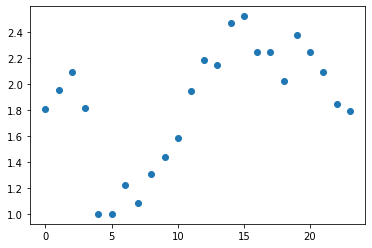

In [218]:
import matplotlib.pyplot as plt
import pandas as pd
df = dataframe_data.loc[dataframe_data['start_station_name']=="Waller & 6th St."]
x=df['start_hour'].to_numpy()
y= df['avg_rides'].to_numpy()
plt.scatter(x, y)

You'll want to inspect your data to ensure it looks like what you expect. Run the line below to get a quick view of the data, and feel free to explore it more if you'd like (if you don't know how to do that, the [Pandas micro-course](https://www.kaggle.com/learn/pandas)) might be helpful.

In [221]:
import numpy as np
from sklearn.linear_model import LinearRegression
X=df.loc[0:,['start_hour','avg_rides']]
reg = LinearRegression().fit(X, y)
reg.score(X, y)

1.0

In [203]:
reg.coef_

array([-8.58909698e-16,  1.00000000e+00])

## Model creation

Now it's time to turn this data into a model. You'll use the `CREATE MODEL` statement that has a structure like: 

```sql
CREATE OR REPLACE MODEL`model_dataset.bike_trips`
OPTIONS(model_type='linear_reg') AS 
-- training data query goes here
SELECT ...
    column_with_labels AS label
    column_with_data_1 
    column_with_data_2
FROM ... 
WHERE ... (Optional)
GROUP BY ... (Optional)
```

The `model_type` and `optimize_strategy` shown here are good parameters to use in general for predicting numeric outcomes with BQML.

**Tip:** Using ```CREATE OR REPLACE MODEL``` rather than just ```CREATE MODEL``` ensures you don't get an error if you want to run this command again without first deleting the model you've created.

## 3) Exercise: Create and train the model

Below, write your query to create and train a linear regression model on the training data.

Write your query below:

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL`model_dataset.bike_trips`
OPTIONS(model_type='linear_reg') AS
SELECT start_station_name,
       EXTRACT(Hour from TIMESTAMP_TRUNC(start_hour, HOUR)) AS start_hour,
       avg(num_rides) AS label
FROM `bike_rides.bike_ride_data`
GROUP BY start_station_name, start_hour

## 4) Exercise: Model evaluation

Now that you have a model, evaluate it's performance on data from 2018. 


> Note that the ML.EVALUATE function will return different metrics depending on what's appropriate for your specific model. You can just use the regular ML.EVALUATE funciton here. (ROC curves are generally used to evaluate binary problems, not linear regression, so there's no reason to plot one here.)

## 4) Exercise: Model evaluation

Now that you have a model, evaluate it's performance on data from 2018. 


> Note that the ML.EVALUATE function will return different metrics depending on what's appropriate for your specific model. You can just use the regular ML.EVALUATE funciton here. (ROC curves are generally used to evaluate binary problems, not linear regression, so there's no reason to plot one here.)

Write your query below:

In [224]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `model_dataset.bike_trips`, (
SELECT start_station_name,
       EXTRACT(Hour from TIMESTAMP_TRUNC(start_hour, HOUR)) AS start_hour,
       avg(num_rides) AS label
FROM `bike_rides.bike_ride_data`
GROUP BY start_station_name, start_hour))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.408014,1.114205,0.033666,0.251412,0.418221,0.41826


You should see that the r^2 score here is negative. Negative values indicate that the model is worse than just predicting the mean rides for each example.

## 5) Theories for poor performance

Why would your model be doing worse than making the most simple prediction based on historical data?

In [ ]:
## Thought question answer here

## 6) Exercise: Looking at predictions

A good way to figure out where your model is going wrong is to look closer at a small set of predictions. Use your model to predict the number of rides for the 22nd & Pearl station in 2018. Compare the mean values of predicted vs actual riders.

Write your query below:

In [226]:
%%bigquery twentysecond
SELECT
  *
FROM
  ML.PREDICT(MODEL `model_dataset.bike_trips`,(
     SELECT start_station_name,
       EXTRACT(Hour from TIMESTAMP_TRUNC(start_hour, HOUR)) AS start_hour,
       avg(num_rides) AS label
     FROM `bike_rides.bike_ride_data`
     GROUP BY start_station_name, start_hour))
WHERE start_station_name='22nd & Pearl'

In [227]:
twentysecond.head(20)
#predicted_mean=twentysecond['predicted_label'].mean()
#print(predicted_mean)
#print (twentysecond['label'].mean())

,predicted_label,start_station_name,start_hour,label
0,3.308426,22nd & Pearl,16,3.630556
1,3.210754,22nd & Pearl,13,3.627841
2,3.243311,22nd & Pearl,14,3.316860
3,3.340984,22nd & Pearl,17,4.322404
4,3.178196,22nd & Pearl,12,3.834734
5,3.275869,22nd & Pearl,15,3.806094
6,3.536329,22nd & Pearl,23,3.334746
7,2.820064,22nd & Pearl,1,2.431507
8,3.373541,22nd & Pearl,18,4.403900
9,3.145639,22nd & Pearl,11,3.414925


What you should see here is that the model is underestimating the number of rides by quite a bit. 

## 7) Exercise: Average daily rides per station

Either something is wrong with the model or something surprising is happening in the 2018 data. 

What could be happening in the data? Write a query to get the average number of riders per station for each year in the dataset and order by the year so you can see the trend. You can use the `EXTRACT` method to get the day and year from the start time timestamp. (You can read up on EXTRACT [in this lesson in the Intro to SQL course](https://www.kaggle.com/dansbecker/order-by)). 

Write your query below:

In [65]:
%%bigquery 
select start_station_name, EXTRACT(DAYOFYEAR from start_hour) as doy,  EXTRACT(YEAR from start_hour) as year, avg(num_rides) as average_rides
from bike_rides.bike_ride_data
group by EXTRACT(YEAR from start_hour), EXTRACT(DAYOFYEAR from start_hour), start_station_name

## 8) What do your results tell you?

Given the daily average riders per station over the years, does it make sense that the model is failing?

In [229]:
## Thought question answer here
# use start_hour timestamp is not a good input.
# extract start hour and use average rides over the day and years 


# 9) Next steps

Given what you've learned, what improvements do you think you could make to your model? Share your ideas on the [Kaggle Learn Forums](https://www.kaggle.com/learn-forum)! (I'll pick a couple of my favorite ideas & send the folks who shared them a Kaggle t-shirt. :)